In [1]:
%matplotlib inline
import numpy as np
import pymc3 as pm
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)

np.random.seed(20090425)

In [2]:
drug = (101,100,102,104,102,97,105,105,98,101,100,123,105,103,100,95,102,106,
        109,102,82,102,100,102,102,101,102,102,103,103,97,97,103,101,97,104,
        96,103,124,101,101,100,101,101,104,100,101)
placebo = (99,101,100,101,102,100,97,101,104,101,102,102,100,105,88,101,100,
           104,100,100,100,101,102,103,97,101,101,100,101,99,101,100,100,
           101,100,99,101,100,102,99,100,99)

In [3]:
y1 = np.array(drug)
y2 = np.array(placebo)

In [4]:
y1.shape

(47,)

In [5]:
y2.shape

(42,)

In [8]:
### Hyperparameters for mu 
# treatment 
u_1_m = y1.mean()
u_1_s = y1.std()
# placebo 
u_2_m = y2.mean()
u_2_s = y2.std()

In [9]:
with pm.Model() as bayesian_t:
    
    group1_mean = pm.Normal("group1_mean", u_1_m, sd=u_1_s)
    group_2_mean = pm.Normal("group2_mean", u_2_m, sd=u_2_s)

In [10]:
bayesian_t

In [11]:
with bayesian_t:
    
    group1_std = pm.Uniform("group1_std", lower=1, upper=10)
    group2_std = pm.Uniform("group2_std", lower=1, upper=10)

In [12]:
bayesian_t

In [13]:
with bayesian_t:
    
    ni = pm.Exponential("ni", 1/30)

In [14]:
### likelihood

with bayesian_t:
    
    # from std to precision, as needed by PyMC3
    lam1 = group1_std**-2
    lam2 = group2_std**-2
    
    group1_lik = pm.StudentT("drug", nu=ni, mu=group1_mean, lam=lam1, observed=y1)
    group2_lik = pm.StudentT("placebo", nu=ni, mu=group_2_mean, lam=lam2, observed=y2)

In [16]:
### Adding deterministic transformation 

with bayesian_t:
    
    diff_of_means = pm.Deterministic("Difference of means", group1_mean - group_2_mean)
    diff_of_stds = pm.Deterministic("Difference of stds", group1_std - group2_std)
    effect_size = pm.Deterministic("Effect size", 
                                  diff_of_means / pm.math.sqrt((group1_std**2 + group2_std**2) / 2)
                                  )

In [17]:
bayesian_t

In [18]:
with bayesian_t:
    trace = pm.sample(5000, jobs=-1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [ni, group2_std, group1_std, group2_mean, group1_mean]
Sampling 4 chains: 100%|██████████| 22000/22000 [00:12<00:00, 1789.06draws/s]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c26b02358>,
      dtype=object)

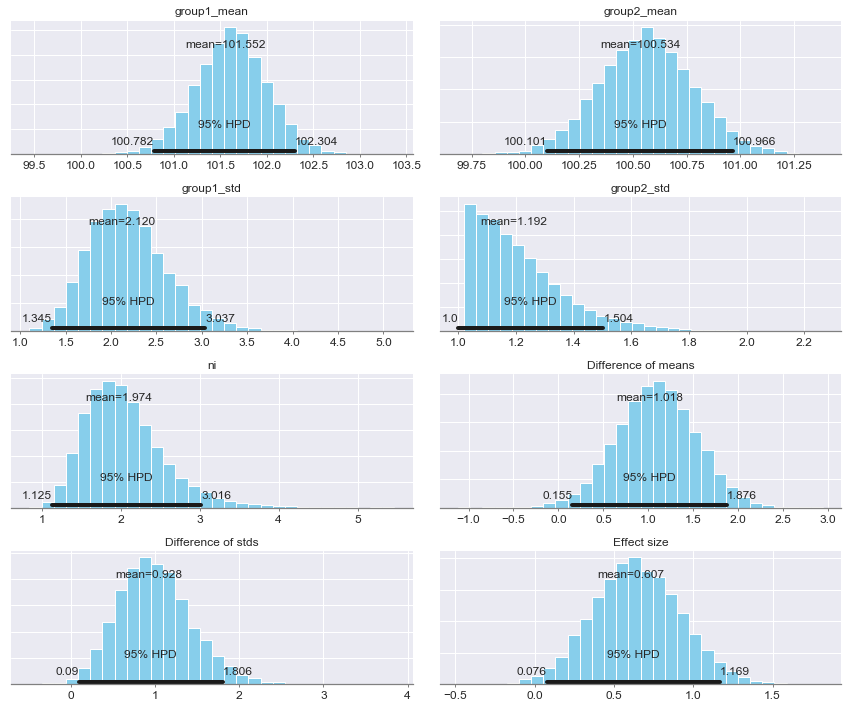

In [22]:
pm.plot_posterior(trace[500:])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x1c284cd2e8>,
      dtype=object)

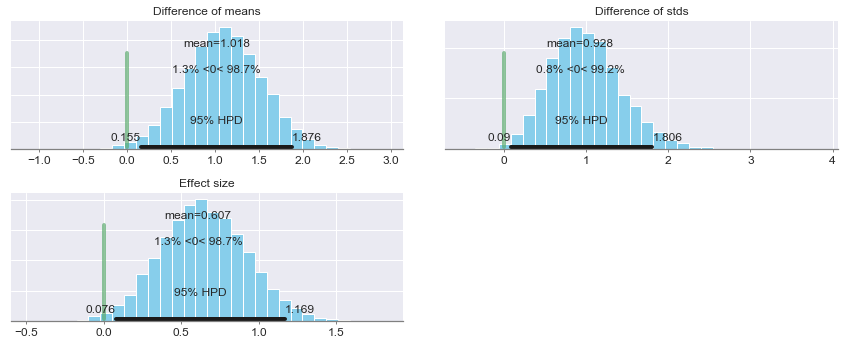

In [23]:
pm.plot_posterior(trace[500:], 
                 varnames=["Difference of means", "Difference of stds", "Effect size"],
                 ref_val=0)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c29f35828>,
      dtype=object)

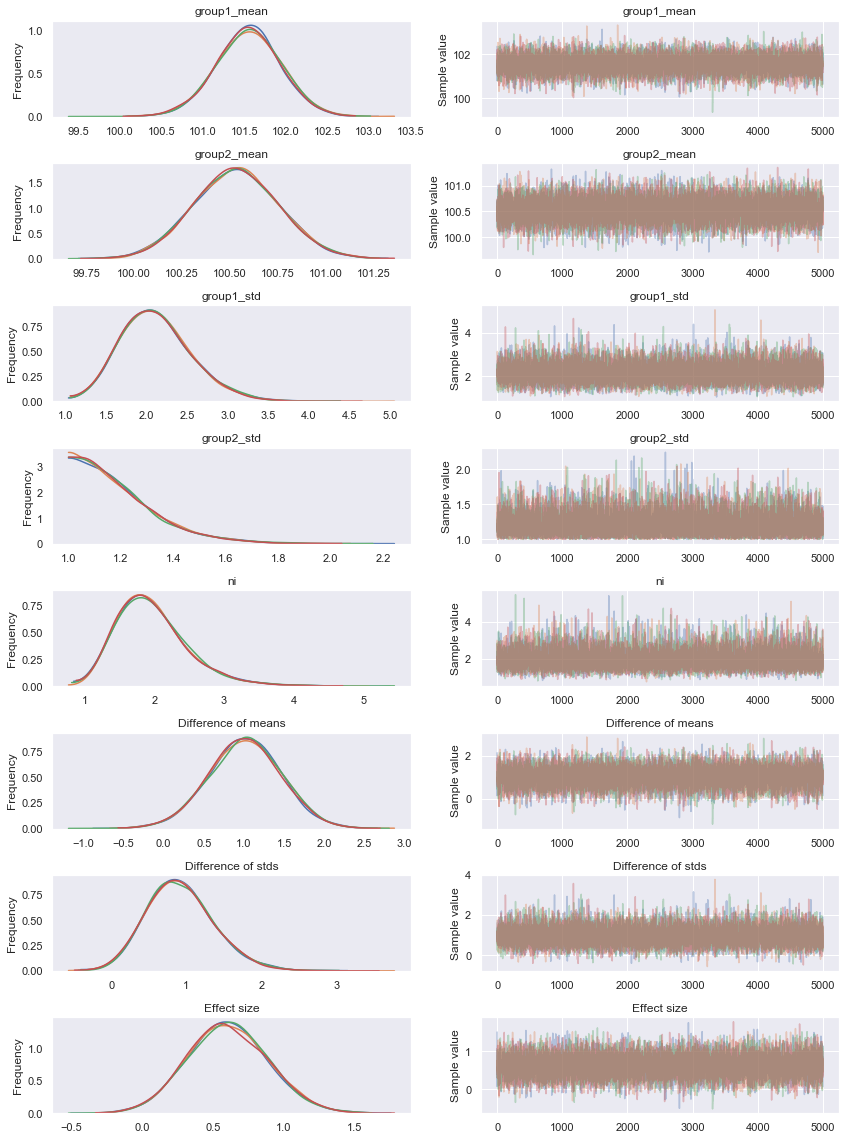

In [35]:
pm.traceplot(trace)

In [24]:
# geweke
from pymc3 import geweke

In [31]:
z = geweke(trace, intervals=10)

In [32]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_context('notebook')

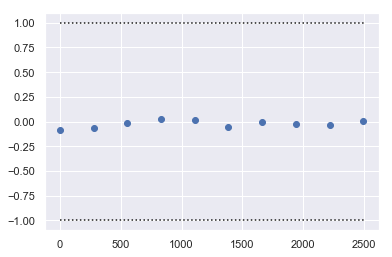

In [34]:
plt.scatter(*z[0]["group1_mean"].T)
plt.hlines([-1, 1], 0, 2500, linestyles="dotted")

In [36]:
# gelman rubin R^2
from pymc3 import gelman_rubin
gelman_rubin(trace[500:])

{'group1_mean': 1.0000602605164255,
 'group2_mean': 0.9999376271810452,
 'group1_std': 1.0000204152760757,
 'group2_std': 0.9999186911604162,
 'ni': 1.0000642143149636,
 'Difference of means': 0.9999899126097828,
 'Difference of stds': 0.9999848276374019,
 'Effect size': 0.9999355122580579}

GridSpec(1, 2, width_ratios=[3, 1])

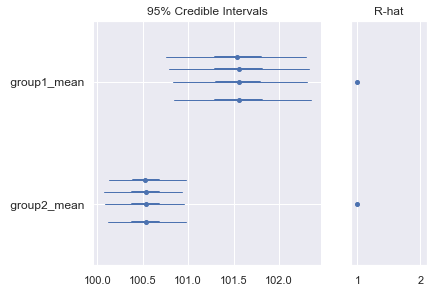

In [39]:
from pymc3 import forestplot

forestplot(trace[500:], varnames=["group1_mean", "group2_mean"])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c2bc73630>,
      dtype=object)

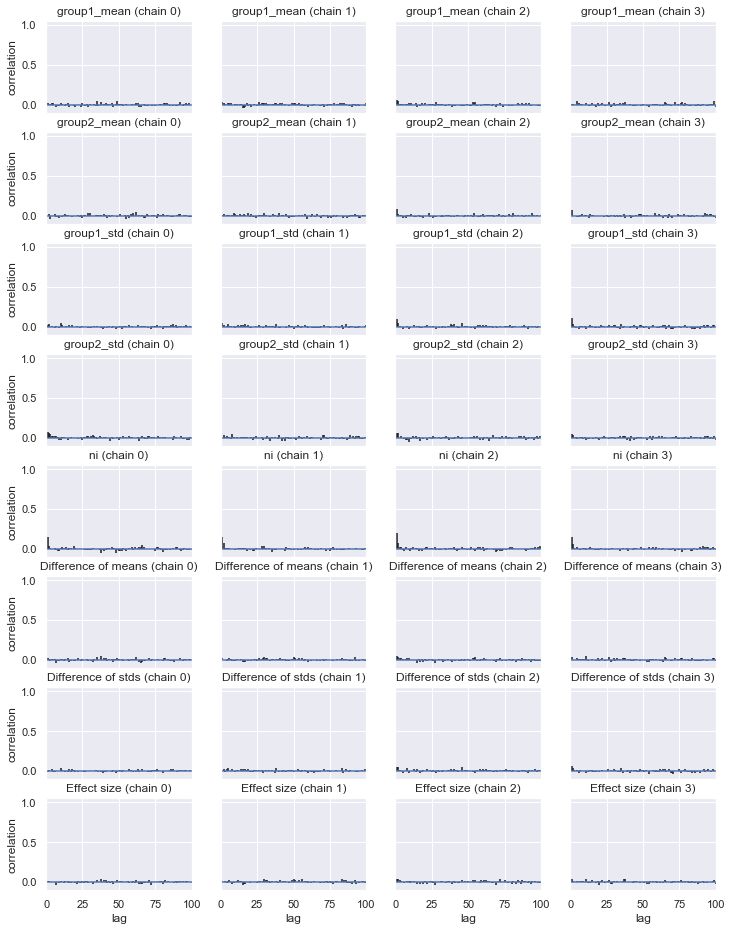

In [40]:
from pymc3 import autocorrplot

autocorrplot(trace[500:])